In [1]:
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
import torch
import torchvision

In [2]:
torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.get_device_name()

(True, 1, 'NVIDIA GeForce RTX 2060')

In [3]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

def accuracy(predicted_logits, reference):
    """
    Compute the ratio of correctly predicted labels
    
    @param predicted_logits: float32 tensor of shape (batch size, num classes)
    @param reference: int64 tensor of shape (batch_size) with the class number
    """
    labels = torch.argmax(predicted_logits, 0)
    correct_predictions = labels.eq(reference)
    return correct_predictions.sum().float() / correct_predictions.nelement()

In [4]:
# Loaded a set of images
root_dir = "data/training/"
image_test = "data/test_set_images"
image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(20, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

n = 10 # Only use 10 images for training

Loading 20 images
satImage_001.png
Loading 20 images
satImage_001.png


Image size = 400,400


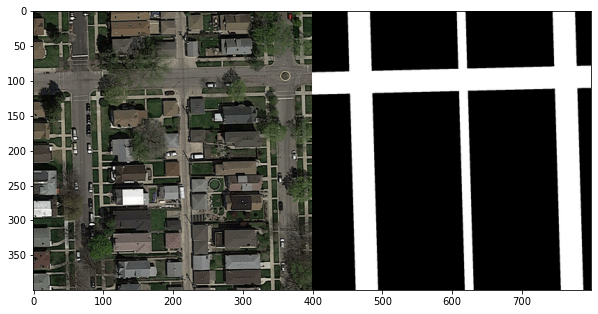

In [5]:
%matplotlib inline
i=5
print('Image size = ' + str(imgs[i].shape[0]) + ',' + str(imgs[i].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[i], gt_imgs[i])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [6]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [7]:
# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat = np.append(feat_m, feat_v)
    return feat

# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
    return X 

In [8]:
DATA_DIR = 'data'

x_train_dir = os.path.join(DATA_DIR, 'training/images')
y_train_dir = os.path.join(DATA_DIR, 'training/groundtruth')

#x_valid_dir = os.path.join(DATA_DIR, 'val')
#y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test_set_images')
#y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [9]:
class RoadsTrainset(torch.utils.data.Dataset):

    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            X, 
            y, 
    ):        
        self.X = X
        self.y = y
    
    def __getitem__(self, i):
        
        # read images and masks
        image = self.X[i]
        X = self.transform(image)
        mask = self.y[i]
        y = torch.from_numpy(np.asarray(mask)).float()
        return X, y
        
        return image, mask
    
    #Transformation, used for data augmentation
    transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])
        
    def __len__(self):
        # return length of 
        return len(self.X)

In [10]:
class RoadsTestset(torch.utils.data.Dataset):

    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            X, 
    ):        
        self.X = X
    
    def __getitem__(self, i):
        
        # read images and masks        
        image = self.X[i]
        X = self.transform(image)
        return X
        
        return image
    
    #Transformation, used for data augmentation
    transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])
        
    def __len__(self):
        # return length of 
        return len(self.X)

In [11]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

#Onehot encode
Y_onehot = np.array([[(1-i), i] for i in Y])
Y_onehot.shape, gt_patches.shape

batch_size = 10
dataset_train = torch.utils.data.DataLoader(RoadsTrainset(img_patches, Y_onehot), batch_size=batch_size, shuffle=True)
dataset_test = torch.utils.data.DataLoader(RoadsTestset(img_patches), batch_size=10, shuffle=True)

In [12]:
class LeNetModel(torch.nn.Module):
  def __init__(self):
    """From: LeCun et al., 1998. Gradient-Based Learning Applied to Document Recognition"""
    super().__init__()
    self.conv1 = torch.nn.Conv2d(3, 10, kernel_size=5)
    self.conv2 = torch.nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = torch.nn.Dropout2d(0.9)
    self.fc1 = torch.nn.Linear(20, 10)
    self.fc2 = torch.nn.Linear(10, 2)

  def forward(self, x):
    relu = torch.nn.functional.relu
    max_pool2d = torch.nn.functional.max_pool2d

    x = relu(max_pool2d(self.conv1(x), 2))
    x = relu(max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(batch_size, -1)
    x = relu(self.fc1(x))
    x = torch.nn.functional.dropout(x, training=self.training)
    x = self.fc2(x)
    return x # Previously there was torch.nn.functional.log_softmax(x, dim=1) here which was incorrect (although the network could still train)

In [13]:
def train(model, criterion, dataset_train, dataset_test, optimizer, num_epochs):
  """
  @param model: torch.nn.Module
  @param criterion: torch.nn.modules.loss._Loss
  @param dataset_train: torch.utils.data.DataLoader
  @param dataset_test: torch.utils.data.DataLoader
  @param optimizer: torch.optim.Optimizer
  @param num_epochs: int
  """
  print("Starting training")
  for epoch in range(num_epochs):
    # Train an epoch
    model.train()
    for batch_x, batch_y in dataset_train:
      batch_x, batch_y = batch_x.to(device), batch_y.to(device)


      prediction = model(batch_x)
      loss = criterion(prediction, batch_y)
    
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


    # Test the quality on the test set
    model.eval()
    accuracies_test = []
    for batch_x, batch_y in dataset_test:
      batch_x, batch_y = batch_x.to(device), batch_y.to(device)

      # Evaluate the network (forward pass)
      prediction = model(batch_x)
      accuracies_test.append(accuracy(prediction, batch_y))

    print("Epoch {} | Test accuracy: {:.5f}".format(epoch, sum(accuracies_test).item()/len(accuracies_test)))

In [17]:
num_epochs = 10
learning_rate = 8e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.CrossEntropyLoss()
model_lenet = LeNetModel().to(device)
optimizer = torch.optim.Adam(model_lenet.parameters(), lr=learning_rate)

train(model_lenet, criterion, dataset_train, dataset_train, optimizer, num_epochs)

Starting training
Epoch 0 | Test accuracy: 0.49920
Epoch 1 | Test accuracy: 0.50000
Epoch 2 | Test accuracy: 0.50000
Epoch 3 | Test accuracy: 0.50000
Epoch 4 | Test accuracy: 0.50000
Epoch 5 | Test accuracy: 0.50000
Epoch 6 | Test accuracy: 0.50000
Epoch 7 | Test accuracy: 0.50000
Epoch 8 | Test accuracy: 0.50000
Epoch 9 | Test accuracy: 0.50000
